In [1]:
#### import packages ####

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import bisect
from pyopls import OPLS
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
import pylab




In [2]:
#### define some simple functions for use later on ####

def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_left(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)


In [3]:
#### Load processed data ####
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_neighbor_data.csv')
df.shape

(5307540, 135)

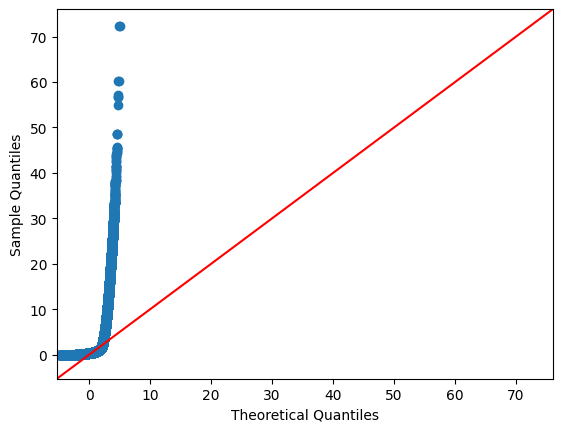

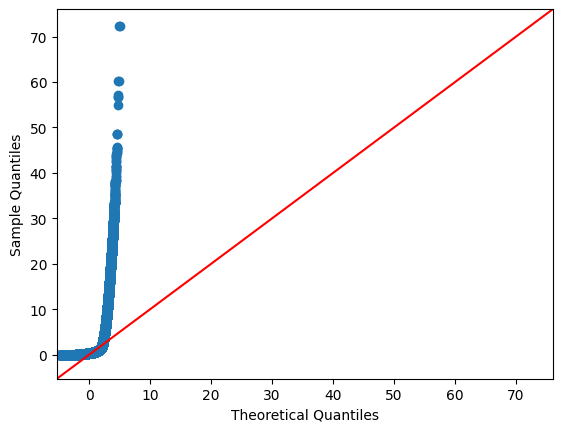

In [4]:
#### QQplots to check if distribution is log normal #### 
# Distiribution of the data with no normalization
y = df['IFNy (Opal 620) Cytoplasm Intensity']
sm.qqplot(y, line='45')


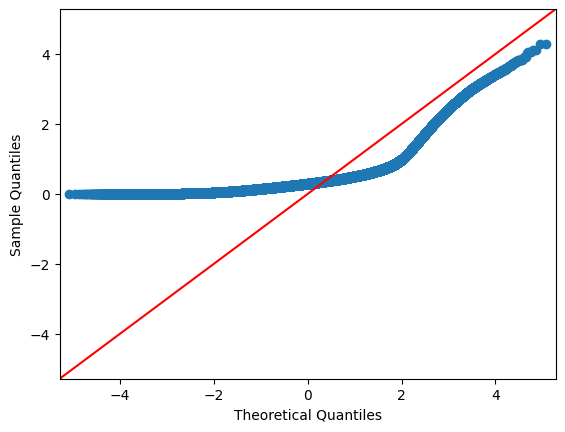

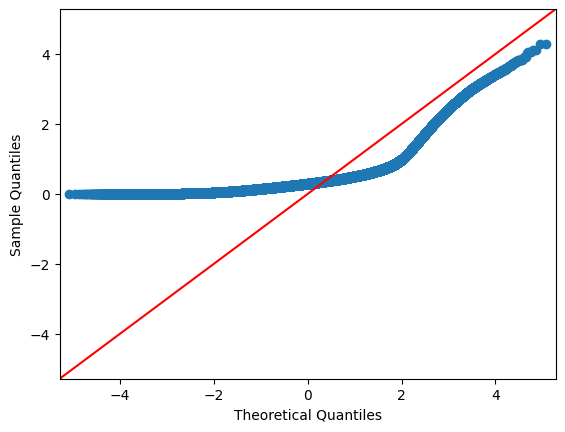

In [5]:
#### QQplots to check if distribution is log normal #### 
# Log+1 transformation greatly improves normality, but high number of zeros divide the distribution into 2 regimes
log_scaled_y = np.log1p(df['IFNy (Opal 620) Cytoplasm Intensity'])
sm.qqplot(log_scaled_y, line='45')


## first ill try removing glass and see how that does

In [6]:
# remove all cells halo deems as 'glass' 

df = df.loc[df['ClassifierLabel'] != 'glass']


In [7]:
# create new variables: total number of neighbors defined as the total number of neighbors of each immune cell subset based on the sum of IFN+ and IFN- or the total number of cancer cell neighbors MHC+ and MHC-
# first tumor then stroma at 30 and 200 um

df['Total CD3+CD8+ Tumor Neighbors_30um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_30um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_30um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_30um'] = df['PanCyto+MHCI+ Tumor Neighbors_30um'] + df['PanCyto+MHCI- Tumor Neighbors_30um']

df['Total CD3+CD8+ Stroma Neighbors_30um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8+IFNy- Stroma Neighbors_30um']
df['Total CD3+CD8- Stroma Neighbors_30um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8-IFNy- Stroma Neighbors_30um']
df['Total CD56+CD3- Stroma Neighbors_30um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_30um'] + df['CD56+CD3-IFNy- Stroma Neighbors_30um']
df['Total PanCyto Stroma Neighbors_30um'] = df['PanCyto+MHCI+ Stroma Neighbors_30um'] + df['PanCyto+MHCI- Stroma Neighbors_30um']

df['Total CD3+CD8+ Tumor Neighbors_200um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_200um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_200um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_200um'] = df['PanCyto+MHCI+ Tumor Neighbors_200um'] + df['PanCyto+MHCI- Tumor Neighbors_200um']

df['Total CD3+CD8+ Stroma Neighbors_200um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8+IFNy- Stroma Neighbors_200um']
df['Total CD3+CD8- Stroma Neighbors_200um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8-IFNy- Stroma Neighbors_200um']
df['Total CD56+CD3- Stroma Neighbors_200um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_200um'] + df['CD56+CD3-IFNy- Stroma Neighbors_200um']
df['Total PanCyto Stroma Neighbors_200um'] = df['PanCyto+MHCI+ Stroma Neighbors_200um'] + df['PanCyto+MHCI- Stroma Neighbors_200um']


In [8]:
# define immune cells 
immune_cells = ['CD3+CD8+IFNy+',
       'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-', 'CD56+CD3-IFNy+',
       'CD56+CD3-IFNy-']

# define neighbor columns
    
neighbors = ['CD3+CD8+IFNy+ Tumor Neighbors_30um','CD3+CD8+IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy- Tumor Neighbors_30um','CD3+CD8+IFNy- Stroma Neighbors_30um',
             'CD3+CD8-IFNy+ Tumor Neighbors_30um','CD3+CD8-IFNy+ Stroma Neighbors_30um','CD3+CD8-IFNy- Tumor Neighbors_30um','CD3+CD8-IFNy- Stroma Neighbors_30um',
             'CD56+CD3-IFNy+ Tumor Neighbors_30um','CD56+CD3-IFNy+ Stroma Neighbors_30um','CD56+CD3-IFNy- Tumor Neighbors_30um','CD56+CD3-IFNy- Stroma Neighbors_30um',
             'PanCyto+MHCI+ Tumor Neighbors_30um','PanCyto+MHCI+ Stroma Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_30um','PanCyto+MHCI- Stroma Neighbors_30um',  
             'CD3+CD8+IFNy+ Tumor Neighbors_200um','CD3+CD8+IFNy+ Stroma Neighbors_200um','CD3+CD8+IFNy- Tumor Neighbors_200um','CD3+CD8+IFNy- Stroma Neighbors_200um',
             'CD3+CD8-IFNy+ Tumor Neighbors_200um','CD3+CD8-IFNy+ Stroma Neighbors_200um','CD3+CD8-IFNy- Tumor Neighbors_200um','CD3+CD8-IFNy- Stroma Neighbors_200um',
             'CD56+CD3-IFNy+ Tumor Neighbors_200um','CD56+CD3-IFNy+ Stroma Neighbors_200um','CD56+CD3-IFNy- Tumor Neighbors_200um','CD56+CD3-IFNy- Stroma Neighbors_200um',
             'PanCyto+MHCI+ Tumor Neighbors_200um','PanCyto+MHCI+ Stroma Neighbors_200um','PanCyto+MHCI- Tumor Neighbors_200um','PanCyto+MHCI- Stroma Neighbors_200um','Total CD3+CD8+ Tumor Neighbors_30um',
             'Total CD3+CD8- Tumor Neighbors_30um','Total CD56+CD3- Tumor Neighbors_30um','Total CD3+CD8+ Stroma Neighbors_30um','Total CD3+CD8- Stroma Neighbors_30um','Total CD56+CD3- Stroma Neighbors_30um',
             'Total CD3+CD8+ Tumor Neighbors_200um','Total CD3+CD8- Tumor Neighbors_200um','Total CD56+CD3- Tumor Neighbors_200um','Total CD3+CD8+ Stroma Neighbors_200um','Total CD3+CD8- Stroma Neighbors_200um',
             'Total CD56+CD3- Stroma Neighbors_200um','Total PanCyto Tumor Neighbors_30um','Total PanCyto Stroma Neighbors_30um','Total PanCyto Tumor Neighbors_200um','Total PanCyto Stroma Neighbors_200um']

In [9]:
# select just the immune cells
df_immune = df[df[immune_cells].any(axis=1)]
df_immune;

In [10]:
# subset to just cell type status 
df_immune_cells = df_immune.loc[:,df_immune.columns.isin(immune_cells)]
df_immune_cells 

,CD3+CD8+IFNy+,CD3+CD8+IFNy-,CD3+CD8-IFNy+,CD3+CD8-IFNy-,CD56+CD3-IFNy+,CD56+CD3-IFNy-
176,0.0,1.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,1.0,0.0,0.0
182,0.0,1.0,0.0,0.0,0.0,0.0
188,0.0,0.0,0.0,1.0,0.0,0.0
192,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
5307503,0.0,0.0,0.0,1.0,0.0,0.0
5307505,0.0,1.0,0.0,0.0,0.0,0.0
5307515,0.0,0.0,0.0,1.0,0.0,0.0
5307518,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# convert to percentages
total_counts = df_immune_cells.iloc[:, :].sum()  # Exclude the 'Category' column from the sum

percentages = (df_immune_cells == 1).sum() / len(df_immune_cells) * 100
percentages

CD3+CD8+IFNy+      0.809523
CD3+CD8+IFNy-     27.608250
CD3+CD8-IFNy+      0.410968
CD3+CD8-IFNy-     62.230884
CD56+CD3-IFNy+     0.164738
CD56+CD3-IFNy-     8.775637
dtype: float64

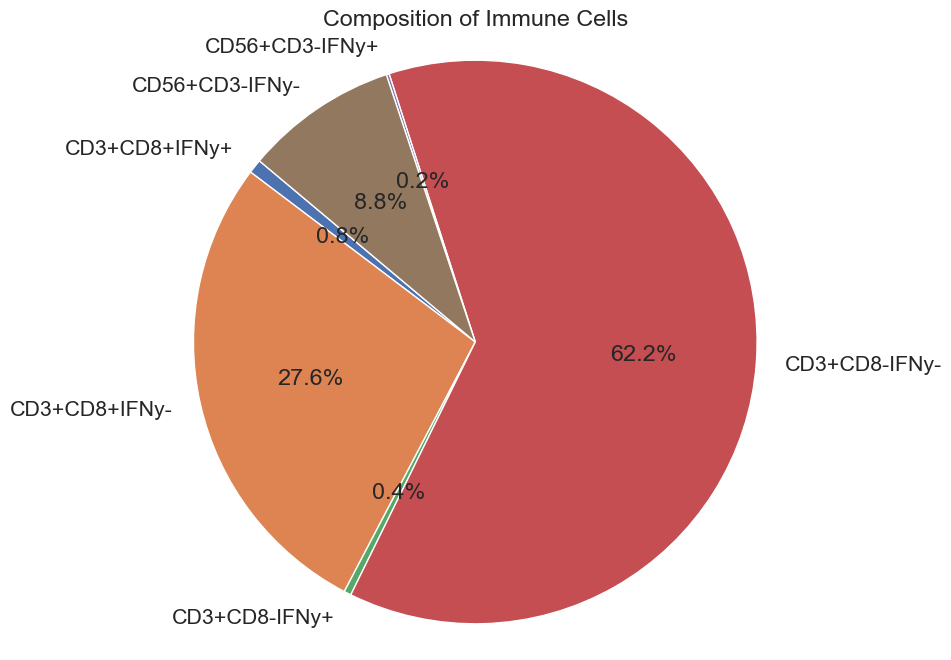

In [12]:
# plot as Pie chart
sns.set(font_scale = 1.4)
sns.set_style("ticks")

plt.figure(figsize=(8, 8))  # Set the figure size
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Composition of Immune Cells')
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig1B.pie_chart.pdf',format='pdf')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2b.pdf', format = 'pdf', bbox_inches = 'tight')

# Show the plot
plt.show()

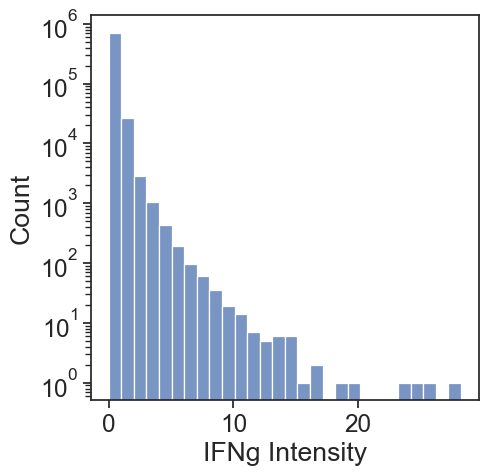

In [13]:
# logscaled histogram of IFNg intensity

sns.set(font_scale = 1.6)
sns.set_style("ticks")


plt.figure(figsize=(5, 5)) 
sns.histplot(df_immune['IFNy (Opal 620) Cytoplasm Intensity'],binwidth=1)
plt.xlabel('IFNg Intensity')
plt.yscale('log')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2c.svg', format = 'svg', bbox_inches = 'tight')

#plt.xscale('log')

Text(0.5, 0, 'IFNg Intensity')

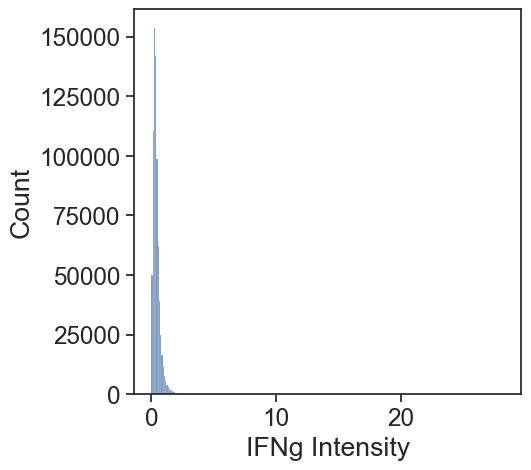

In [14]:
# unscaled histogram of IFNg intensity

sns.set(font_scale = 1.6)
sns.set_style("ticks")


plt.figure(figsize=(5, 5)) 
sns.histplot(df_immune['IFNy (Opal 620) Cytoplasm Intensity'],binwidth=0.1)
plt.xlabel('IFNg Intensity')
#plt.yscale('log')
# plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2c.svg', format = 'svg', bbox_inches = 'tight')

#plt.xscale('log')

In [15]:
# define X and Y matrices for down stream analysis
X_unscaled = df_immune[ neighbors]
X = np.log1p(X_unscaled) 
y = df_immune['IFNy (Opal 620) Cytoplasm Intensity']
y = np.log1p(y)
y;

<Axes: >

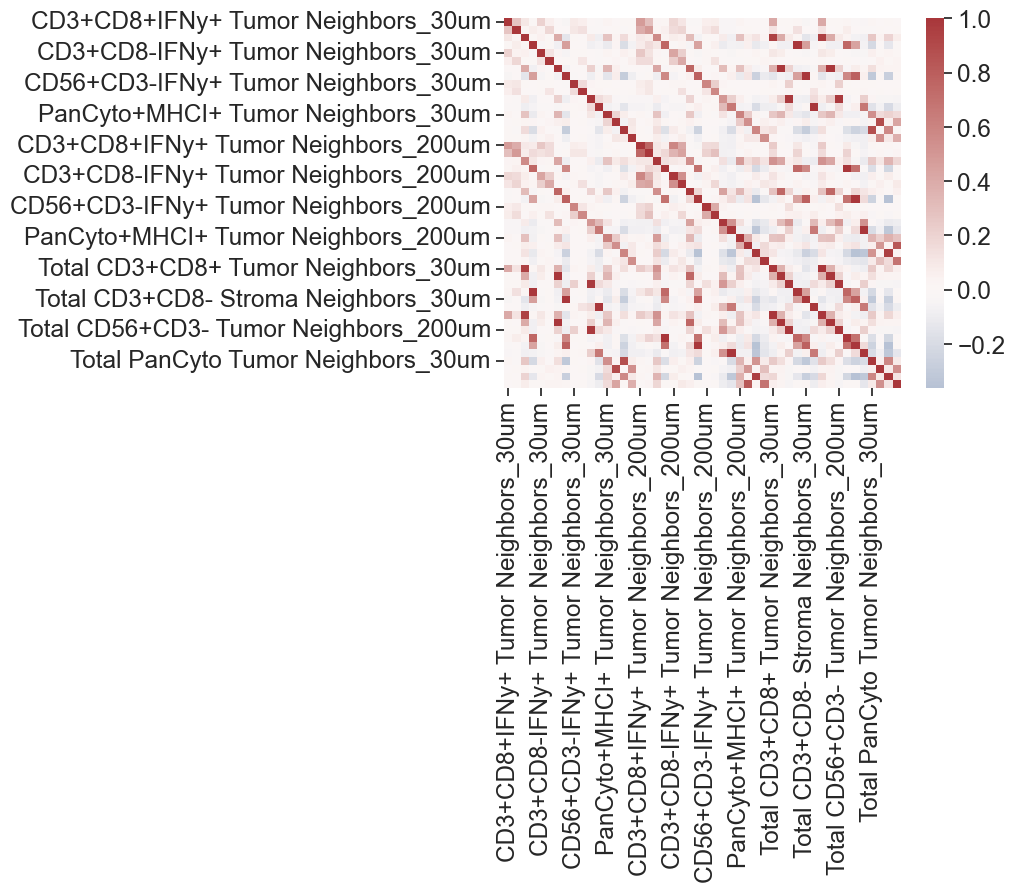

In [16]:
# correlation heatmap of the variables compared to each other
corr = X_unscaled.corr()
sns.heatmap(corr, cmap = 'vlag', center = 0, )

for export into matlab
X['IFNg_intensity'] = y
export_df = X
>export_df.to_csv('/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_log1p.csv')
>
>export_df.columns

# Checkpoint 1

In [17]:
# load checkpoint data
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_log1p.csv', index_col=0)
df

,CD3+CD8+IFNy+ Tumor Neighbors_30um,CD3+CD8+IFNy+ Stroma Neighbors_30um,CD3+CD8+IFNy- Tumor Neighbors_30um,CD3+CD8+IFNy- Stroma Neighbors_30um,CD3+CD8-IFNy+ Tumor Neighbors_30um,CD3+CD8-IFNy+ Stroma Neighbors_30um,CD3+CD8-IFNy- Tumor Neighbors_30um,CD3+CD8-IFNy- Stroma Neighbors_30um,CD56+CD3-IFNy+ Tumor Neighbors_30um,CD56+CD3-IFNy+ Stroma Neighbors_30um,...,CD3+CD8-IFNy- Stroma Neighbors_200um,CD56+CD3-IFNy+ Tumor Neighbors_200um,CD56+CD3-IFNy+ Stroma Neighbors_200um,CD56+CD3-IFNy- Tumor Neighbors_200um,CD56+CD3-IFNy- Stroma Neighbors_200um,PanCyto+MHCI+ Tumor Neighbors_200um,PanCyto+MHCI+ Stroma Neighbors_200um,PanCyto+MHCI- Tumor Neighbors_200um,PanCyto+MHCI- Stroma Neighbors_200um,IFNg_intensity
176,0.0,0.0,1.386294,0.000000,0.0,0.0,1.098612,0.000000,0.0,0.0,...,1.609438,0.0,0.0,0.0,0.0,2.708050,0.000000,4.510860,0.000000,0.187413
179,0.0,0.0,1.609438,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,...,1.609438,0.0,0.0,0.0,0.0,2.833213,0.000000,4.634729,0.000000,0.219369
182,0.0,0.0,1.386294,0.000000,0.0,0.0,1.098612,0.000000,0.0,0.0,...,1.609438,0.0,0.0,0.0,0.0,2.944439,0.000000,4.828314,0.000000,0.327181
188,0.0,0.0,0.000000,0.000000,0.0,0.0,1.386294,1.098612,0.0,0.0,...,1.945910,0.0,0.0,0.0,0.0,3.555348,0.000000,5.398163,0.000000,0.104623
192,0.0,0.0,0.000000,0.000000,0.0,0.0,1.791759,1.098612,0.0,0.0,...,2.197225,0.0,0.0,0.0,0.0,3.761200,0.000000,5.468060,0.000000,0.080356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307503,0.0,0.0,0.000000,0.693147,0.0,0.0,0.000000,0.000000,0.0,0.0,...,1.791759,0.0,0.0,0.0,0.0,3.091042,1.791759,5.480639,2.302585,0.426847
5307505,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,...,1.945910,0.0,0.0,0.0,0.0,3.091042,1.791759,5.598422,2.397895,0.908553
5307515,0.0,0.0,0.000000,0.000000,0.0,0.0,0.693147,0.693147,0.0,0.0,...,0.693147,0.0,0.0,0.0,0.0,2.772589,1.609438,5.488938,1.098612,1.058489
5307518,0.0,0.0,0.000000,0.000000,0.0,0.0,0.693147,0.693147,0.0,0.0,...,0.693147,0.0,0.0,0.0,0.0,2.833213,1.609438,5.455321,1.098612,0.914209


In [18]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

## Run oPLS

In [19]:
%%time 
# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_mse = mean_squared_error(y, processed_y_pred)
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
#processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 100

# List to store permutation accuracies
permuted_mse_list = []
permuted_q2_list = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(2)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    #permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules

    permuted_mse = mean_squared_error(y, permuted_pred)
    permuted_q_squared = r2_score(y, permuted_pred) 
    #permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_mse_list.append(permuted_mse)
    permuted_q2_list.append(permuted_q_squared)
    


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]

CPU times: user 8min 24s, sys: 50min 2s, total: 58min 26s
Wall time: 2min 57s


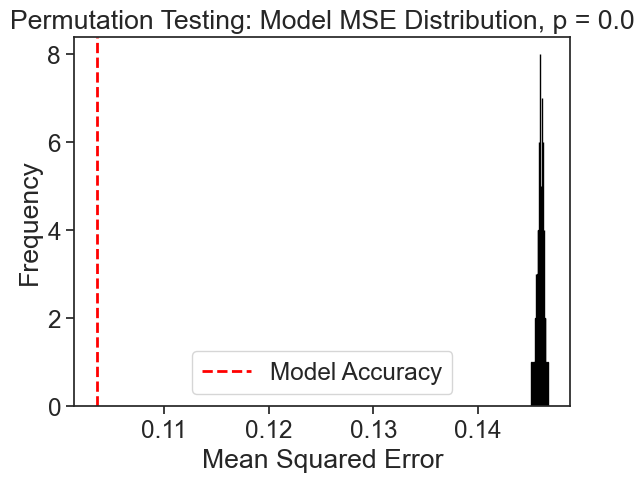

In [20]:
#permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
permuted_mse_list.sort()

result_count = count_values_greater_than(permuted_mse_list, processed_mse)
p = (100-result_count)/100
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_mse_list, bins=50, edgecolor='black')
plt.axvline(x=processed_mse, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model MSE Distribution, p = {p}')
plt.legend()
plt.show()

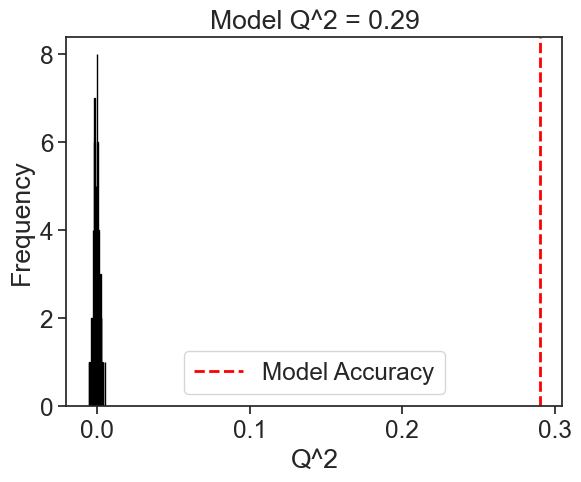

In [21]:
# Plotting the histogram
plt.hist(permuted_q2_list, bins=50, edgecolor='black')
plt.axvline(x=processed_q_squared, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Q^2')
plt.ylabel('Frequency')
plt.title(f'Model Q^2 = {np.round(processed_q_squared,3)}')
plt.legend()
plt.show()

# troubleshooting variance explained

### The orthogonalized model is 2 distinct steps - in the first orthogonalization step we identify and remove components that are othrogonal to y. Then, once these components have been removed from our X matrix, PLS is used to identify components the orthogonalized X that maximizes covariance with y. This is the output of our model which we analyze.
#### We are using the opls function implementation to orthogonalize and then sklearn pls to perform the plsr. 

In [22]:
total_variance_in_x = np.sum(np.var(Z, axis=0))  # Scalar: total variance across all features

# Compute variance in the PLS components (latent variables) -this is on the output of the orthogonalization. 
# 
variance_in_x = np.var(pls_model.x_scores_, axis=0)  # Variance explained by each latent variable

# Normalize variance by total variance
fractions_of_explained_variance = variance_in_x / total_variance_in_x  # Shape will match PLS components
fractions_of_explained_variance 

array([0.16282311, 0.09773477])

In [23]:
# Total variance in Y (sum of variances across all features of Y if multi-dimensional)
total_variance_in_y = np.sum(np.var(y, axis=0))

# Variance explained by PLS components (latent variables in Y)
variance_in_y = np.var(pls_model.y_scores_, axis=0)

# Normalize variance by total variance to get the fraction explained
fractions_of_explained_variance_in_y = variance_in_y / total_variance_in_y
fractions_of_explained_variance_in_y

array([  89.78622388, 3679.95709579])

In [24]:
total_variance_in_x = np.sum(np.var(Z, axis=0))  # Scalar: total variance across all features

# Compute variance in the PLS components (latent variables) - this from the OPLS model 
variance_in_x = np.var(opls.x_scores_, axis=0)  # Variance explained by each latent variable

# Normalize variance by total variance
fractions_of_explained_variance = variance_in_x / total_variance_in_x  # Shape will match PLS components

AttributeError: 'OPLS' object has no attribute 'x_scores_'

##### I think this is the crux of it -> the orthogonalization process is scaling the y variance explained 

# Results from matlab running export_df
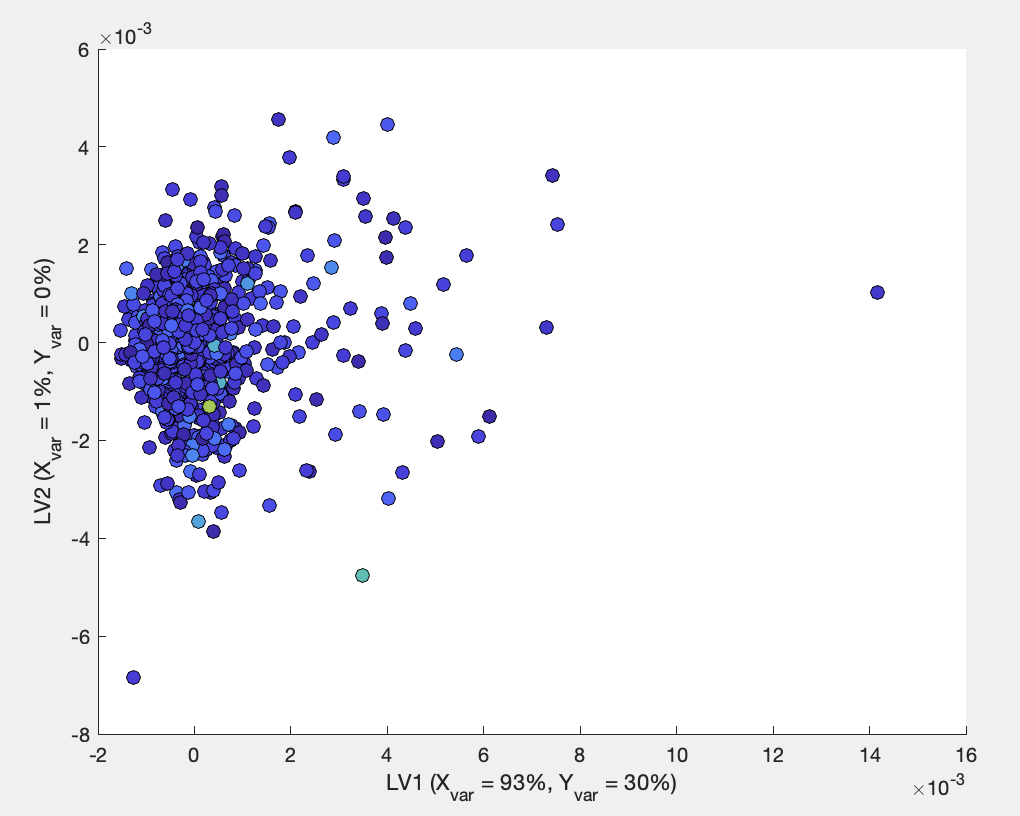

## Plotting the python version

In [ ]:
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])                
df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
df['true label'] = y

In [ ]:
sampled_df = df.sample(10000)

In [ ]:
y.describe()

In [ ]:
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

plt.scatter(sampled_df['lv1'], sampled_df['lv2'], c = sampled_df['true label'], cmap = 'crest', alpha = 0.7, norm=divnorm)
plt.title(f'X Scores: (MSE = {np.round(processed_mse,3)})\np ={p_round}')
plt.xlabel('LV1 (X_var = 93%, Yvar = 30%)')
plt.ylabel('LV2 (X_var = 1%, Yvar = 0%)')
#plt.legend(loc='upper right')
cb = plt.colorbar(label="logp1(IFNg inntensity)", orientation="vertical") 
cb.set_ticks([0,1,2,3,4])
cb.ax.set_yscale('linear')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2d.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

plt.scatter(sampled_df['lv1'], sampled_df['lv2'], c = sampled_df['true label'], cmap = 'crest', alpha = 0.7, norm=divnorm)
plt.title(f'X Scores: (MSE = {np.round(processed_mse,3)})\np ={p_round}')
#plt.xlabel('LV1 (X_var = 93%, Yvar = 30%)')
#plt.ylabel('LV2 (X_var = 1%, Yvar = 0%)')
#plt.legend(loc='upper right')
cb = plt.colorbar(label="logp1(IFNg inntensity)", orientation="vertical") 
cb.set_ticks([0,1,2,3,4])
cb.ax.set_yscale('linear')
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2d.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# without sampling this plot has too many points
plt.scatter(df['lv1'], df['lv2'], c = df['true label'], cmap = 'crest', alpha = 0.5, s =10)
plt.title(f'X Scores: (MSE = {np.round(processed_mse,3)})\np ={p_round}')
plt.xlabel('LV1 (X_var = 93%, Yvar = 30%)')
plt.ylabel('LV2 (X_var = 1%, Yvar = 0%)')
plt.colorbar(label="logp1(IFNg inntensity)", orientation="vertical") 

plt.legend(loc='upper right')
plt.show()

In [ ]:

plt.figure(figsize=(10,6))
sns.relplot(x='lv1', y='lv2', hue='true label',cmap = 'crest', data=sampled_df)
sns.kdeplot(x = sampled_df.lv1, y = sampled_df.lv2, data = sampled_df)
plt.title('Density vs Scatter');

In [ ]:
plt.figure(figsize=(6, 10)) 
x_loadings = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
x_loadings['color'] = np.where(x_loadings['loadings'] > 0, 'high', 'low')
colors = {'high': (0.14573579, 0.29354139, 0.49847009), 'low': (0.48942421, 0.72854938, 0.56751036)}

x_loadings['abs_val'] = abs(x_loadings['loadings'])
x_loadings = x_loadings.sort_values(by = 'abs_val', ascending=False)
sns.barplot(data = x_loadings, x=x_loadings['loadings'],y = x_loadings.index, hue = 'color', palette = colors)
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('Loadings for oPLSDA model')

In [ ]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)
sns.set(font_scale = 1.2)
sns.set_style("ticks")
plt.figure(figsize=(4, 10)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, 'high', 'low')
colors = {'high': (0.14573579, 0.29354139, 0.49847009), 'low': (0.48942421, 0.72854938, 0.56751036)}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('VIPs for oPLSDA model')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2e_long.pdf', format = 'pdf', bbox_inches = 'tight')


In [ ]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores

vips = vip_efficient(pls_model)
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 

sns.barplot(data = loadings_vips[:13], x=loadings_vips['VIPs'][:13],y = loadings_vips.index[:13], hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.title('VIPs for oPLSDA model')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/fig2e.pdf', format = 'pdf', bbox_inches = 'tight')


## Univariate plotting

In [ ]:
sns.scatterplot(x = X_unscaled['CD3+CD8+IFNy+ Tumor Neighbors_200um'], y = y)

In [ ]:
# ROC equivalent: residuals plot

residuals = y - processed_y_pred

plt.scatter(processed_y_pred, residuals, alpha = 0.05)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure2/figS', format = 'pdf', bbox_inches = 'tight')

plt.show()

In [ ]:
# ROC equivalent: residuals plot

plt.scatter(processed_y_pred, y, alpha = 0.05)
plt.axline((0, 0), slope=1., linestyle='--',color='r', label='by slope')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

In [ ]:
x_columns = [
 'PanCyto+MHCI+ Neighbors_200um',
 'PanCyto+MHCI- Neighbors_200um',
 'CD3+CD8+IFNy+ Neighbors_200um',
 'CD3+CD8+IFNy- Neighbors_200um',
 'CD3+CD8-IFNy+ Neighbors_200um',
 'CD3+CD8-IFNy- Neighbors_200um',
 'CD56+CD3-IFNy+ Neighbors_200um',
 'CD56+CD3-IFNy- Neighbors_200um']

y_column = 'IFNy (Opal 620) Cytoplasm Intensity'

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(x_columns), figsize=(15, 6))

# Iterate over x columns and create scatter plots
for i, x_column in enumerate(x_columns):
    axes[i].scatter(df[x_column], df[y_column], s = 1, alpha = 0.5)
    axes[i].set_xlabel(x_column, rotation=90)
    axes[i].set_ylabel(y_column)
    #axes[i].set_title(f'Scatter Plot: {x_column} vs {y_column}')
    #axes[i].tick_params(axis='x', rotation=45)  
    
plt.tight_layout()
plt.show()

In [ ]:
x_columns = ['PanCyto+MHCI+ Neighbors_30um',
 'PanCyto+MHCI- Neighbors_30um',
 'CD3+CD8+IFNy+ Neighbors_30um',
 'CD3+CD8+IFNy- Neighbors_30um',
 'CD3+CD8-IFNy+ Neighbors_30um',
 'CD3+CD8-IFNy- Neighbors_30um',
 'CD56+CD3-IFNy+ Neighbors_30um',
 'CD56+CD3-IFNy- Neighbors_30um']

y_column = 'IFNy (Opal 620) Cytoplasm Intensity'

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(x_columns), figsize=(15, 6))

# Iterate over x columns and create scatter plots
for i, x_column in enumerate(x_columns):
    axes[i].scatter(df[x_column], df[y_column], s = 1, alpha = 0.5)
    axes[i].set_xlabel(x_column, rotation=90)
    axes[i].set_ylabel(y_column)
    #axes[i].set_title(f'Scatter Plot: {x_column} vs {y_column}')
    #axes[i].tick_params(axis='x', rotation=45)  
    
plt.tight_layout()
plt.show()

# Looking for a Representative region in the images of these results

In [ ]:
# select just the immune cells
#### Load processed data ####
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/neighbor_data/tumor_stroma/tumor_stroma_merged_neighbor_data.csv')
df.shape

# define immune cells 
immune_cells = ['CD3+CD8+IFNy+',
       'CD3+CD8+IFNy-', 'CD3+CD8-IFNy+', 'CD3+CD8-IFNy-', 'CD56+CD3-IFNy+',
       'CD56+CD3-IFNy-']

# create new variables: total number of neighbors defined as the total number of neighbors of each immune cell subset based on the sum of IFN+ and IFN- or the total number of cancer cell neighbors MHC+ and MHC-
# first tumor then stroma at 30 and 200 um

df['Total CD3+CD8+ Tumor Neighbors_30um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_30um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_30um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_30um'] = df['PanCyto+MHCI+ Tumor Neighbors_30um'] + df['PanCyto+MHCI- Tumor Neighbors_30um']

df['Total CD3+CD8+ Stroma Neighbors_30um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8+IFNy- Stroma Neighbors_30um']
df['Total CD3+CD8- Stroma Neighbors_30um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_30um'] + df['CD3+CD8-IFNy- Stroma Neighbors_30um']
df['Total CD56+CD3- Stroma Neighbors_30um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_30um'] + df['CD56+CD3-IFNy- Stroma Neighbors_30um']
df['Total PanCyto Stroma Neighbors_30um'] = df['PanCyto+MHCI+ Stroma Neighbors_30um'] + df['PanCyto+MHCI- Stroma Neighbors_30um']

df['Total CD3+CD8+ Tumor Neighbors_200um'] = df['CD3+CD8+IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8+IFNy- Tumor Neighbors_30um']
df['Total CD3+CD8- Tumor Neighbors_200um'] = df['CD3+CD8-IFNy+ Tumor Neighbors_30um'] + df['CD3+CD8-IFNy- Tumor Neighbors_30um']
df['Total CD56+CD3- Tumor Neighbors_200um'] = df['CD56+CD3-IFNy+ Tumor Neighbors_30um'] + df['CD56+CD3-IFNy- Tumor Neighbors_30um']
df['Total PanCyto Tumor Neighbors_200um'] = df['PanCyto+MHCI+ Tumor Neighbors_200um'] + df['PanCyto+MHCI- Tumor Neighbors_200um']

df['Total CD3+CD8+ Stroma Neighbors_200um'] = df['CD3+CD8+IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8+IFNy- Stroma Neighbors_200um']
df['Total CD3+CD8- Stroma Neighbors_200um'] = df['CD3+CD8-IFNy+ Stroma Neighbors_200um'] + df['CD3+CD8-IFNy- Stroma Neighbors_200um']
df['Total CD56+CD3- Stroma Neighbors_200um'] = df['CD56+CD3-IFNy+ Stroma Neighbors_200um'] + df['CD56+CD3-IFNy- Stroma Neighbors_200um']
df['Total PanCyto Stroma Neighbors_200um'] = df['PanCyto+MHCI+ Stroma Neighbors_200um'] + df['PanCyto+MHCI- Stroma Neighbors_200um']

# define neighbor columns
    
neighbors = ['CD3+CD8+IFNy+ Tumor Neighbors_30um','CD3+CD8+IFNy+ Stroma Neighbors_30um','CD3+CD8+IFNy- Tumor Neighbors_30um','CD3+CD8+IFNy- Stroma Neighbors_30um',
             'CD3+CD8-IFNy+ Tumor Neighbors_30um','CD3+CD8-IFNy+ Stroma Neighbors_30um','CD3+CD8-IFNy- Tumor Neighbors_30um','CD3+CD8-IFNy- Stroma Neighbors_30um',
             'CD56+CD3-IFNy+ Tumor Neighbors_30um','CD56+CD3-IFNy+ Stroma Neighbors_30um','CD56+CD3-IFNy- Tumor Neighbors_30um','CD56+CD3-IFNy- Stroma Neighbors_30um',
             'PanCyto+MHCI+ Tumor Neighbors_30um','PanCyto+MHCI+ Stroma Neighbors_30um','PanCyto+MHCI- Tumor Neighbors_30um','PanCyto+MHCI- Stroma Neighbors_30um',  
             'CD3+CD8+IFNy+ Tumor Neighbors_200um','CD3+CD8+IFNy+ Stroma Neighbors_200um','CD3+CD8+IFNy- Tumor Neighbors_200um','CD3+CD8+IFNy- Stroma Neighbors_200um',
             'CD3+CD8-IFNy+ Tumor Neighbors_200um','CD3+CD8-IFNy+ Stroma Neighbors_200um','CD3+CD8-IFNy- Tumor Neighbors_200um','CD3+CD8-IFNy- Stroma Neighbors_200um',
             'CD56+CD3-IFNy+ Tumor Neighbors_200um','CD56+CD3-IFNy+ Stroma Neighbors_200um','CD56+CD3-IFNy- Tumor Neighbors_200um','CD56+CD3-IFNy- Stroma Neighbors_200um',
             'PanCyto+MHCI+ Tumor Neighbors_200um','PanCyto+MHCI+ Stroma Neighbors_200um','PanCyto+MHCI- Tumor Neighbors_200um','PanCyto+MHCI- Stroma Neighbors_200um','Total CD3+CD8+ Tumor Neighbors_30um',
             'Total CD3+CD8- Tumor Neighbors_30um','Total CD56+CD3- Tumor Neighbors_30um','Total CD3+CD8+ Stroma Neighbors_30um','Total CD3+CD8- Stroma Neighbors_30um','Total CD56+CD3- Stroma Neighbors_30um',
             'Total CD3+CD8+ Tumor Neighbors_200um','Total CD3+CD8- Tumor Neighbors_200um','Total CD56+CD3- Tumor Neighbors_200um','Total CD3+CD8+ Stroma Neighbors_200um','Total CD3+CD8- Stroma Neighbors_200um',
             'Total CD56+CD3- Stroma Neighbors_200um','Total PanCyto Tumor Neighbors_30um','Total PanCyto Stroma Neighbors_30um','Total PanCyto Tumor Neighbors_200um','Total PanCyto Stroma Neighbors_200um']

df_immune = df[df[immune_cells].any(axis=1)]
df_immune;

# Calculate the 95th percentile
top_5_percent_threshold = df_immune['CD3+CD8+IFNy+ Stroma Neighbors_30um'].quantile(0.95)

# Subset the DataFrame to select rows where the value is in the top 5%
top_5_percent_df = df_immune[df_immune['CD3+CD8+IFNy+ Stroma Neighbors_30um'] > top_5_percent_threshold]


In [ ]:
top_5_percent_df = top_5_percent_df[['ImageLocation','IFNy',
'CD3+CD8+IFNy+',
 'CD3+CD8+IFNy-',
 'CD3+CD8-IFNy+',
 'CD3+CD8-IFNy-',
 'CD56+CD3-IFNy+',
 'CD56+CD3-IFNy-']]

In [ ]:
top_5_percent_df[top_5_percent_df['IFNy'] == 1.0].ImageLocation.value_counts()

In [ ]:
# coloring by PanCyto positivity
rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 3.21.19\IMAGES 3.25.19\MAD17-205_[46450,16512]_component_data.tif']


plt.style.use('dark_background')
plt.style.use('default')

plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Scatterplot
ax = sns.scatterplot(data=rep_image, x='XCenter', y='YCenter', hue='PanCyto', palette='Paired', size='CellArea', sizes=(2.5, 75))

# Title and legend adjustments
ax.set_title('PanCyto', fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 1.05))

# Axes adjustments
ax.invert_yaxis()

# Show the plot
plt.show()


In [ ]:
# coloring by IFNy intensity

rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 3.21.19\IMAGES 3.25.19\MAD17-205_[46450,16512]_component_data.tif']


plt.style.use('dark_background')
plt.style.use('default')

plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Scatterplot
ax = sns.scatterplot(data=rep_image, x='XCenter', y='YCenter', hue='IFNy (Opal 620) Cytoplasm Intensity',palette= 'viridis', hue_norm = (0,20),size='CellArea', sizes=(5, 150))

# Title and legend adjustments
ax.set_title('IFNy', fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 1.05))

# Axes adjustments
ax.invert_yaxis()

# Show the plot
plt.show()


In [ ]:
# coloring by log IFNy intensity

rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 3.21.19\IMAGES 3.25.19\MAD17-205_[46450,16512]_component_data.tif']
rep_image['log_IFNg'] = np.log1p(rep_image['IFNy (Opal 620) Cytoplasm Intensity'])


plt.style.use('dark_background')
plt.style.use('default')

plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Scatterplot
ax = sns.scatterplot(data=rep_image, x='XCenter', y='YCenter', hue='log_IFNg',palette= 'viridis',size='CellArea', sizes=(5, 150))

# Title and legend adjustments
ax.set_title('IFNy', fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 1.05))

# Axes adjustments
ax.invert_yaxis()

# Show the plot
plt.show()


In [ ]:
# other reference image colored by log IFNg
rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-249_[44416,12014]_component_data.tif']
rep_image['log_IFNg'] = np.log1p(rep_image['IFNy (Opal 620) Cytoplasm Intensity'])

plt.style.use('dark_background')
plt.style.use('default')

plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Scatterplot
ax = sns.scatterplot(data=rep_image, x='XCenter', y='YCenter', hue='log_IFNg',palette= 'viridis', hue_norm = (1,3), size='CellArea', sizes=(2.5, 75))

# Title and legend adjustments
ax.set_title('CD56+CD3-IFNy-', fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 1.05))

# Axes adjustments
ax.invert_yaxis()

# Show the plot
plt.show()


In [ ]:
rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-249_[44416,12014]_component_data.tif']
rep_image['log_IFNg'] = np.log1p(rep_image['IFNy (Opal 620) Cytoplasm Intensity'])

plt.style.use('dark_background')
plt.style.use('default')

plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Scatterplot
ax = sns.scatterplot(data=rep_image, x='XCenter', y='YCenter', hue='log_IFNg',palette= 'viridis', hue_norm = (1,3), size='CellArea', sizes=(2.5, 75))

# Title and legend adjustments
ax.set_title('CD56+CD3-IFNy-', fontsize=20)
ax.legend(bbox_to_anchor=(1.02, 1.05))

# Axes adjustments
ax.invert_yaxis()

# Show the plot
plt.show()


In [ ]:
# multi sectional image showing:
# A) PanCyto  B) IFNg+ helper T cells C) IFNg+ CTLs,  D)IFNG+ NK cells  and E) IFNg intensity
rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-249_[44416,12014]_component_data.tif']

plt.style.use('dark_background')
plt.style.use('default')

fig, axes = plt.subplots(3, 2, figsize=(36,24))
#fig.subplots_adjust(wspace=0.5, hspace = 0.2)

ax0 = sns.scatterplot(ax = axes[0,0], data = rep_image, x = 'XCenter', y = 'YCenter', hue= 'PanCyto',  palette = 'Paired_r', size='CellArea', sizes=(5, 150))
ax0.set_title('PanCyto+', fontsize = 20)  
ax0.legend(bbox_to_anchor=(1.02, 1.05))
#ax0.get_legend().remove()
#ax0.set_ylim(0, 500)
#ax0.set_xlim(0, 1000)
ax0.invert_yaxis()

custom_palette = sns.color_palette("Paired")[2:] 
ax1 = sns.scatterplot(ax = axes[0,1], data=rep_image, x = 'XCenter', y = 'YCenter', hue= 'CD3+CD8-IFNy+',  palette = custom_palette, size='CellArea', sizes=(5, 150))
ax1.set_title('IFNy intensity', fontsize = 20)  
ax1.legend(bbox_to_anchor=(1.02, 1.05), loc='upper left', borderaxespad=0)
#ax1.get_legend().remove()
#ax1.set_ylim(0, 1500)
#ax1.set_xlim(0, 2000)
ax1.invert_yaxis()
#
custom_palette = sns.color_palette("Paired")[4:] 
ax2 = sns.scatterplot(ax = axes[1,0], data=rep_image, x = 'XCenter', y = 'YCenter', hue= 'CD3+CD8+IFNy+',  palette = custom_palette, size='CellArea', sizes=(5, 150))
#ax2 = sns.scatterplot(ax = axes[1,0], data = late_stage_df[late_stage_df.ImageLocation == late_test_set[2]], x = 'XCenter', y = 'YCenter', hue= 'CD56+CD3-IFNy- Tumor Neighbors_200um',  palette = 'viridis', size='CellArea', sizes=(2.5, 75),hue_norm = (0,60))
ax2.set_title('CD3+CD8+IFNy+', fontsize = 20)  
ax2.legend(bbox_to_anchor=(1.02, 1.05))
#ax0.get_legend().remove()
#ax0.set_ylim(0, 500)
#ax0.set_xlim(0, 1000)
ax2.invert_yaxis()

custom_palette = sns.color_palette("Paired")[6:] 
ax3 = sns.scatterplot(ax = axes[1,1], data=rep_image, x='XCenter', y='YCenter', hue='CD56+CD3-IFNy+',palette= custom_palette,size='CellArea', sizes=(5, 150))
#ax3 = sns.scatterplot(ax = axes[1,1], data = early_stage_df[early_stage_df.ImageLocation == early_test_set[2]], x = 'XCenter', y = 'YCenter', hue= 'CD56+CD3-IFNy- Tumor Neighbors_200um', palette = 'viridis_r',  size='CellArea',sizes=(2.5, 75), hue_norm = (0,60))
ax3.set_title('CD56+CD3-IFNg-', fontsize = 20)  
ax3.legend(bbox_to_anchor=(1.02, 1.05), loc='upper left', borderaxespad=0)
#ax1.get_legend().remove()
#ax1.set_ylim(0, 1500)
#ax1.set_xlim(0, 2000)
ax3.invert_yaxis()
#

ax4 = sns.scatterplot(ax = axes[2,0], data=rep_image, x='XCenter', y='YCenter', hue='IFNy (Opal 620) Cytoplasm Intensity',palette= 'viridis', hue_norm = (0,20),size='CellArea', sizes=(5, 150))
ax4.set_title('IFNg intensity', fontsize = 20)  
ax4.legend(bbox_to_anchor=(1.02, 1))
#ax4.get_legend().remove()
#ax3.set_ylim(0, 1500)
#ax3.set_xlim(0, 2000)
ax4.invert_yaxis()


plt.tight_layout()
#fig.suptitle('NK cells in in patients with high vs low grade tumors', fontsize=30, y=1.05)
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/representative_fig.pdf', format = 'pdf')
#plt.savefig('vectra_analysis_results/recreated_images/intensity_stains.png', bbox_inches = 'tight')
#sns.boxplot(data=df, x='team', y='points', ax=axes[0,0])
#sns.boxplot(data=df, x='team', y='assists', ax=axes[0,1])
#sns.boxplot(data=df, x='team', y='rebounds', ax=axes[1,0])
#sns.boxplot(data=df, x='team', y='blocks', ax=axes[1,1])

In [ ]:
# same as above but for a different region
rep_image = df.loc[df['ImageLocation'] == r'E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-249_[44416,12014]_component_data.tif']

plt.style.use('dark_background')
plt.style.use('default')

fig, axes = plt.subplots(2, 1, figsize=(16,12))
#fig.subplots_adjust(wspace=0.5, hspace = 0.2)

ax0 = sns.scatterplot(ax = axes[0], data = rep_image, x = 'XCenter', y = 'YCenter', hue= 'PanCyto',  palette = 'Paired_r', size='CellArea', sizes=(5, 150))
ax0.set_title('PanCyto+', fontsize = 20)  
ax0.legend(bbox_to_anchor=(1.02, 1.05))
#ax0.get_legend().remove()
#ax0.set_ylim(0, 500)
#ax0.set_xlim(0, 1000)
ax0.invert_yaxis()

#custom_palette = sns.color_palette("Paired")[2:] 
#ax1 = sns.scatterplot(ax = axes[0,1], data=rep_image, x = 'XCenter', y = 'YCenter', hue= 'CD3+CD8-IFNy+',  palette = custom_palette, size='CellArea', sizes=(5, 150))
#ax1.set_title('IFNy intensity', fontsize = 20)  
#ax1.legend(bbox_to_anchor=(1.02, 1.05), loc='upper left', borderaxespad=0)
##ax1.get_legend().remove()
##ax1.set_ylim(0, 1500)
##ax1.set_xlim(0, 2000)
#ax1.invert_yaxis()
##
#custom_palette = sns.color_palette("Paired")[4:] 
#ax2 = sns.scatterplot(ax = axes[1,0], data=rep_image, x = 'XCenter', y = 'YCenter', hue= 'CD3+CD8+IFNy+',  palette = custom_palette, size='CellArea', sizes=(5, 150))
##ax2 = sns.scatterplot(ax = axes[1,0], data = late_stage_df[late_stage_df.ImageLocation == late_test_set[2]], x = 'XCenter', y = 'YCenter', hue= 'CD56+CD3-IFNy- Tumor Neighbors_200um',  palette = 'viridis', size='CellArea', sizes=(2.5, 75),hue_norm = (0,60))
#ax2.set_title('CD3+CD8+IFNy+', fontsize = 20)  
#ax2.legend(bbox_to_anchor=(1.02, 1.05))
##ax0.get_legend().remove()
##ax0.set_ylim(0, 500)
##ax0.set_xlim(0, 1000)
#ax2.invert_yaxis()
#
#custom_palette = sns.color_palette("Paired")[6:] 
#ax3 = sns.scatterplot(ax = axes[1,1], data=rep_image, x='XCenter', y='YCenter', hue='CD56+CD3-IFNy+',palette= custom_palette,size='CellArea', sizes=(5, 150))
##ax3 = sns.scatterplot(ax = axes[1,1], data = early_stage_df[early_stage_df.ImageLocation == early_test_set[2]], x = 'XCenter', y = 'YCenter', hue= 'CD56+CD3-IFNy- Tumor Neighbors_200um', palette = 'viridis_r',  size='CellArea',sizes=(2.5, 75), hue_norm = (0,60))
#ax3.set_title('CD56+CD3-IFNg-', fontsize = 20)  
#ax3.legend(bbox_to_anchor=(1.02, 1.05), loc='upper left', borderaxespad=0)
##ax1.get_legend().remove()
##ax1.set_ylim(0, 1500)
##ax1.set_xlim(0, 2000)
#ax3.invert_yaxis()
#

ax4 = sns.scatterplot(ax = axes[1], data=rep_image, x='XCenter', y='YCenter', hue='IFNy (Opal 620) Cytoplasm Intensity',palette= 'viridis', hue_norm = (0,10),size='CellArea', sizes=(5, 150))
ax4.set_title('CD56CD3-IFNg- Tumor neighbors 30um', fontsize = 20)  
ax4.legend(bbox_to_anchor=(1.02, 1))
#ax4.get_legend().remove()
#ax3.set_ylim(0, 1500)
#ax3.set_xlim(0, 2000)
ax4.invert_yaxis()


plt.tight_layout()
#fig.suptitle('NK cells in in patients with high vs low grade tumors', fontsize=30, y=1.05)
#plt.savefig('/scratch/gh8sj/kate_gabe_paper_figures/figure6/representative_fig.pdf', format = 'pdf')
#plt.savefig('vectra_analysis_results/recreated_images/intensity_stains.png', bbox_inches = 'tight')
#sns.boxplot(data=df, x='team', y='points', ax=axes[0,0])
#sns.boxplot(data=df, x='team', y='assists', ax=axes[0,1])
#sns.boxplot(data=df, x='team', y='rebounds', ax=axes[1,0])
#sns.boxplot(data=df, x='team', y='blocks', ax=axes[1,1])